In [1]:
from scipy.signal import butter, lfilter, cheby2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import csv

In [2]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b,a

def bandpass_filter(data, lowcut, highcut, fs, order):
    b,a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
def mov_avg_and_detrend(data, w, dtr):
    size = len(data)
    result = np.zeros(size)
    half_window = (w - 1) // 2

    for i in range(size):
        start_index = max(i - half_window, 0)
        end_index = min(i + half_window + 1, size)

        mean = np.mean(data[start_index:end_index])

        if dtr != 0:
            result[i] = data[i] - mean
        else:
            result[i] = mean

    return result

In [6]:
def detect_peak_trough_default_scipy(s, ma):
    peak_finalist = signal.find_peaks(s, ma)[0]
    for idx in range(len(peak_finalist) - 1):
        region = s[peak_finalist[idx]:peak_finalist[idx + 1]]

    return peak_finalist

In [7]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/raw_data_11_8_2024_100Hz.csv")
ir1 = data["ir1"].to_list()
ir2 = data["ir2"].to_list()
for i in range(len(ir1)):
  ir1[i] = ir1[i] * -1
  ir2[i] = ir2[i] * -1


In [16]:

def detect_peak_trough_moving_average_threshold(s, w1, w2, beta):
    peak_finalist = []

    Z = np.array([np.max([0, z]) for z in s])
    y = Z**2

    ma_peak = get_moving_average(y, w1)
    ma_beat = get_moving_average(y, w2)
 
    z_mean = np.mean(y)

    alpha = beta * z_mean + ma_beat
    thr1 = ma_beat + alpha
    block_of_interest = np.zeros(len(thr1))
    for i in range(len(ma_peak)):
        if ma_peak[i] > thr1[i]:
            block_of_interest[i] = 0.1

    thr2 = w1
    BOI_idx = np.where(block_of_interest > 0)[0]
    BOI_diff = np.diff(BOI_idx)
    BOI_width_idx = np.where(BOI_diff > 1)[0]
    BOI_width_idx = np.append(BOI_width_idx, len(BOI_idx) - 1)

    for i, val in enumerate(np.arange(len(BOI_width_idx))):
        if i == 0:
            BOI_width = BOI_width_idx[i]
        else:
            BOI_width = BOI_width_idx[i] - BOI_width_idx[i - 1]


        if BOI_width >= thr2:
            if i == 0:
                left_idx = 0
            else:
                left_idx = BOI_width_idx[i - 1] + 1
            right_idx = BOI_width_idx[i]
            region = y[BOI_idx[left_idx] : BOI_idx[right_idx] + 1]
            peak_finalist.append(BOI_idx[left_idx] + np.argmax(region))

    return peak_finalist

In [18]:
output_file = "/content/drive/MyDrive/Colab Notebooks/result.csv"

In [36]:
# PPG1 peaks of 100Hz data
expected_peaks_ppg1 = [80, 169, 255, 342, 432, 513, 685, 767, 852, 938, 1019, 1102, 1180, 1262, 1340, 1415, 1490, 1570, 1651, 1732, 1815, 1900, 1981, 2065, 2149, 2227, 2305, 2383, 2465, 2543, 2622, 2703, 2783]

In [39]:
# PPG2 peaks
expected_peaks_ppg2 = [29, 76, 164, 250, 282, 322, 376, 426, 507, 586, 674, 757, 840, 923, 1003, 1085, 1166, 1248, 1325, 1399, 1475, 1552, 1633, 1712, 1795, 1879, 1960, 2046, 2125,
2204, 2281, 2360, 2438, 2520, 2597, 2677, 2754]

In [ ]:
import numpy as np

def calculate_SE_TP_FN_FP(detected_peaks, ground_truth_peaks):
    TP = sum([1 for peak in detected_peaks if peak in ground_truth_peaks])
    FN = len(ground_truth_peaks) - TP
    FP = len(detected_peaks) - TP
    SE = TP / (TP + FN) if (TP + FN) > 0 else 0
    PP = TP / (TP + FP) if (TP + FP) > 0 else 0
    return SE, PP, TP, FN, FP

def auto_tune_parameters(s, w1_range, w2_range, beta_range):
    best_params = {}
    best_SE = 0
    best_PP = 0
    best_ACC = 0

    y = bandpass_filter(s, 0.5, 5.0, 100, order=2)
    y = y[200:]
    ydtr = mov_avg_and_detrend(y, 51, dtr = 1)
    ma = mov_avg_and_detrend(ydtr, 151, dtr = 0)
    ground_truth_peaks = expected_peaks_ppg2

    with open(output_file, mode='w', newline='') as file:
      writer = csv.writer(file)
      # Ghi header cho file CSV
      writer.writerow(['w1', 'w2', 'beta', 'SE', 'PP', 'TP', 'FN', 'FP', 'ACC'])

      for w1 in w1_range:
          for w2 in w2_range:
              for beta in beta_range:

                  detected_peaks = detect_peak_trough_moving_average_threshold(ydtr, w1, w2, beta)

                  # Evaluating detected peaks
                  SE, PP, TP, FN, FP = calculate_SE_TP_FN_FP(detected_peaks, ground_truth_peaks)
                  SE *= 100
                  PP *= 100
                  Accuracy = (TP / (TP + FP + FN)) * 100

                  print(f"w1={w1}, w2={w2}, beta={beta} => SE: {SE:.2f}, +P: {PP:.2f}, TP: {TP}, FN: {FN}, FP: {FP}, Acc: {Accuracy}")
                  writer.writerow([w1, w2, beta, SE, PP, TP, FN, FP, Accuracy])

                  # Update best parameters if both SE and PP are high
                  if Accuracy >= best_ACC:
                      best_SE = SE
                      best_PP = PP
                      best_ACC = Accuracy
                      best_params = {'w1': w1, 'w2': w2, 'beta': beta}

    print(f"Best SE: {best_SE:.2f}, Best +P: {best_PP:.2f}, Best Acc: {best_ACC:.2f}, with parameters: {best_params}")
    return best_params

# Example usage
w1_range = range(5, 12)  # Example range for w1
w2_range = range(54, 70)  # Example range for w2
lowf_range = np.arange(0.5, 1.1, 0.1)
highf_range = np.arange(5.0, 13.0, 1.0)
beta_range = np.arange(0, 0.11, 0.01)  # Example range for beta

best_params = auto_tune_parameters(ir2, w1_range, w2_range, beta_range)


In [ ]:
!pip install heartpy

In [24]:
import heartpy as hp

In [34]:
y = bandpass_filter(ir2, 0.5, 5.0, 100, order=2)
y = y[200:]
ydtr = mov_avg_and_detrend(y, 51, dtr = 1)
wd, m = hp.process(ydtr, sample_rate = 100.0)

bpm: 76.183147
ibi: 787.575758
sdnn: 83.703311
sdsd: 84.871207
rmssd: 98.341079
pnn20: 0.516129
pnn50: 0.129032
hr_mad: 30.000000
sd1: 67.888474
sd2: 61.832071
s: 13187.416241
sd1/sd2: 1.097949
breathingrate: 0.230858


<Figure size 1200x400 with 0 Axes>

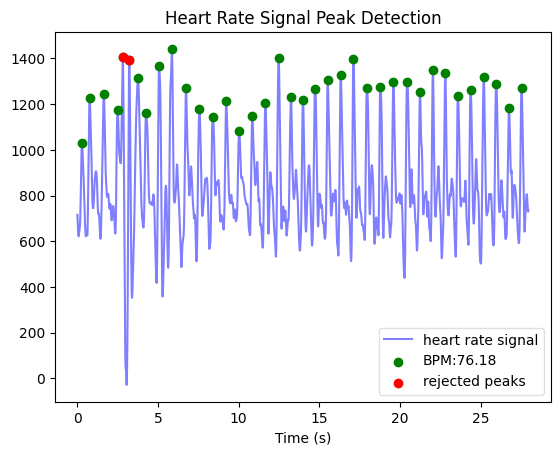

In [35]:
#set large figure
plt.figure(figsize=(12,4))

#call plotter
hp.plotter(wd, m)

#display measures computed
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))